Arturo Sotillo Barraca - 100484973

# Práctica 2: Clustering de Semillas
En esta práctica aplicaremos técnicas de clustering sobre un conjunto de datos de semillas, para identificar agrupaciones naturales en los datos y determinar qué técnicas funcionan mejor.

### Carga de datos

In [1]:
# Importamos las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Fijamos la semilla para reproducibilidad (con mi NIA)
np.random.seed(484973) 

# Cargar los datos correctamente
df = pd.read_csv('semillas.csv', sep=',')

# Verificamos que se haya cargado correctamente
print("Primeras 5 filas del dataset:")
print(df.head())

# Verificamos las dimensiones
print("\nDimensiones del dataset:", df.shape)

Primeras 5 filas del dataset:
    area  perimetro  compacidad  longitud  anchura  asimetria  surco  clase
0  15.26      14.84      0.8710     5.763    3.312      2.221  5.220      1
1  14.88      14.57      0.8811     5.554    3.333      1.018  4.956      1
2  14.29      14.09      0.9050     5.291    3.337      2.699  4.825      1
3  13.84      13.94      0.8955     5.324    3.379      2.259  4.805      1
4  16.14      14.99      0.9034     5.658    3.562      1.355  5.175      1

Dimensiones del dataset: (210, 8)


Ahora, vamos a explorar brevemente los datos para entender su estructura:

In [2]:
# Información básica del dataset
print("Información del dataset:")
df.info()

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Verificar si hay valores nulos
print("\n¿Hay valores nulos en el dataset?")
print(df.isnull().sum())

# Separación de características y etiquetas
X = df.iloc[:, :-1].values  # Todas las columnas excepto la última
y = df.iloc[:, -1].values   # Última columna (clase)

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)
print("Valores únicos en y:", np.unique(y))

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        210 non-null    float64
 1   perimetro   210 non-null    float64
 2   compacidad  210 non-null    float64
 3   longitud    210 non-null    float64
 4   anchura     210 non-null    float64
 5   asimetria   210 non-null    float64
 6   surco       210 non-null    float64
 7   clase       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB

Estadísticas descriptivas:
             area   perimetro  compacidad    longitud     anchura   asimetria  \
count  210.000000  210.000000  210.000000  210.000000  210.000000  210.000000   
mean    14.847524   14.559286    0.870999    5.628533    3.258605    3.700201   
std      2.909699    1.305959    0.023629    0.443063    0.377714    1.503557   
min     10.590000   12.410000    0.808100    4.899000    2

### Comparación visual de los diferentes escaladores con PCA

Vamos a comparar visualmente cuál de los tres escaladores (MinMaxScaler, RobustScaler, StandardScaler) es más apropiado para nuestro conjunto de datos de semillas. Para ello, aplicaremos PCA para reducir la dimensionalidad a 2 componentes y podremos visualizar los resultados.

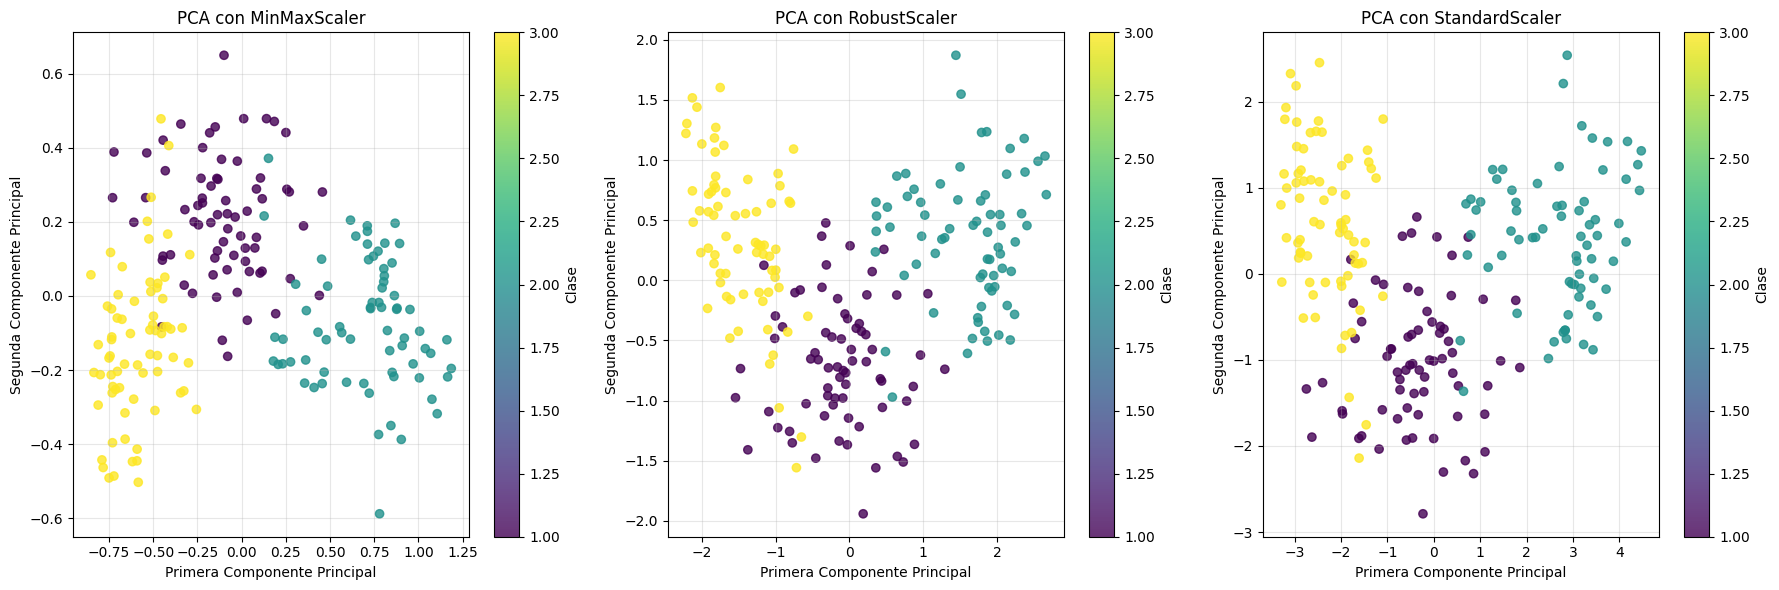

In [3]:
# Crear pipelines con diferentes escaladores y PCA
pipelines = {
    'MinMaxScaler': Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components=2))]),
    'RobustScaler': Pipeline([('scaler', RobustScaler()), ('pca', PCA(n_components=2))]),
    'StandardScaler': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
}

# Aplicar cada pipeline y visualizar los resultados
plt.figure(figsize=(18, 6))

for i, (name, pipeline) in enumerate(pipelines.items()):
    X_scaled_pca = pipeline.fit_transform(X)
    
    plt.subplot(1, 3, i+1)
    scatter = plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
    plt.title(f'PCA con {name}')
    plt.xlabel('Primera Componente Principal')
    plt.ylabel('Segunda Componente Principal')
    plt.colorbar(scatter, label='Clase')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Análisis de los resultados de los escaladores
A continuación, vamos a examinar el impacto que tiene cada escalador en la distribución de los datos después de aplicar PCA. Esto nos ayudará a seleccionar el más adecuado para nuestro análisis de clustering.

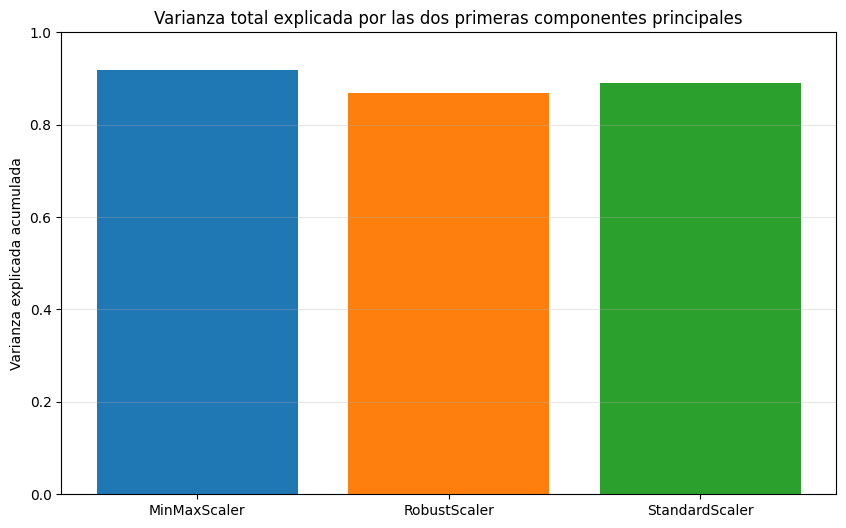

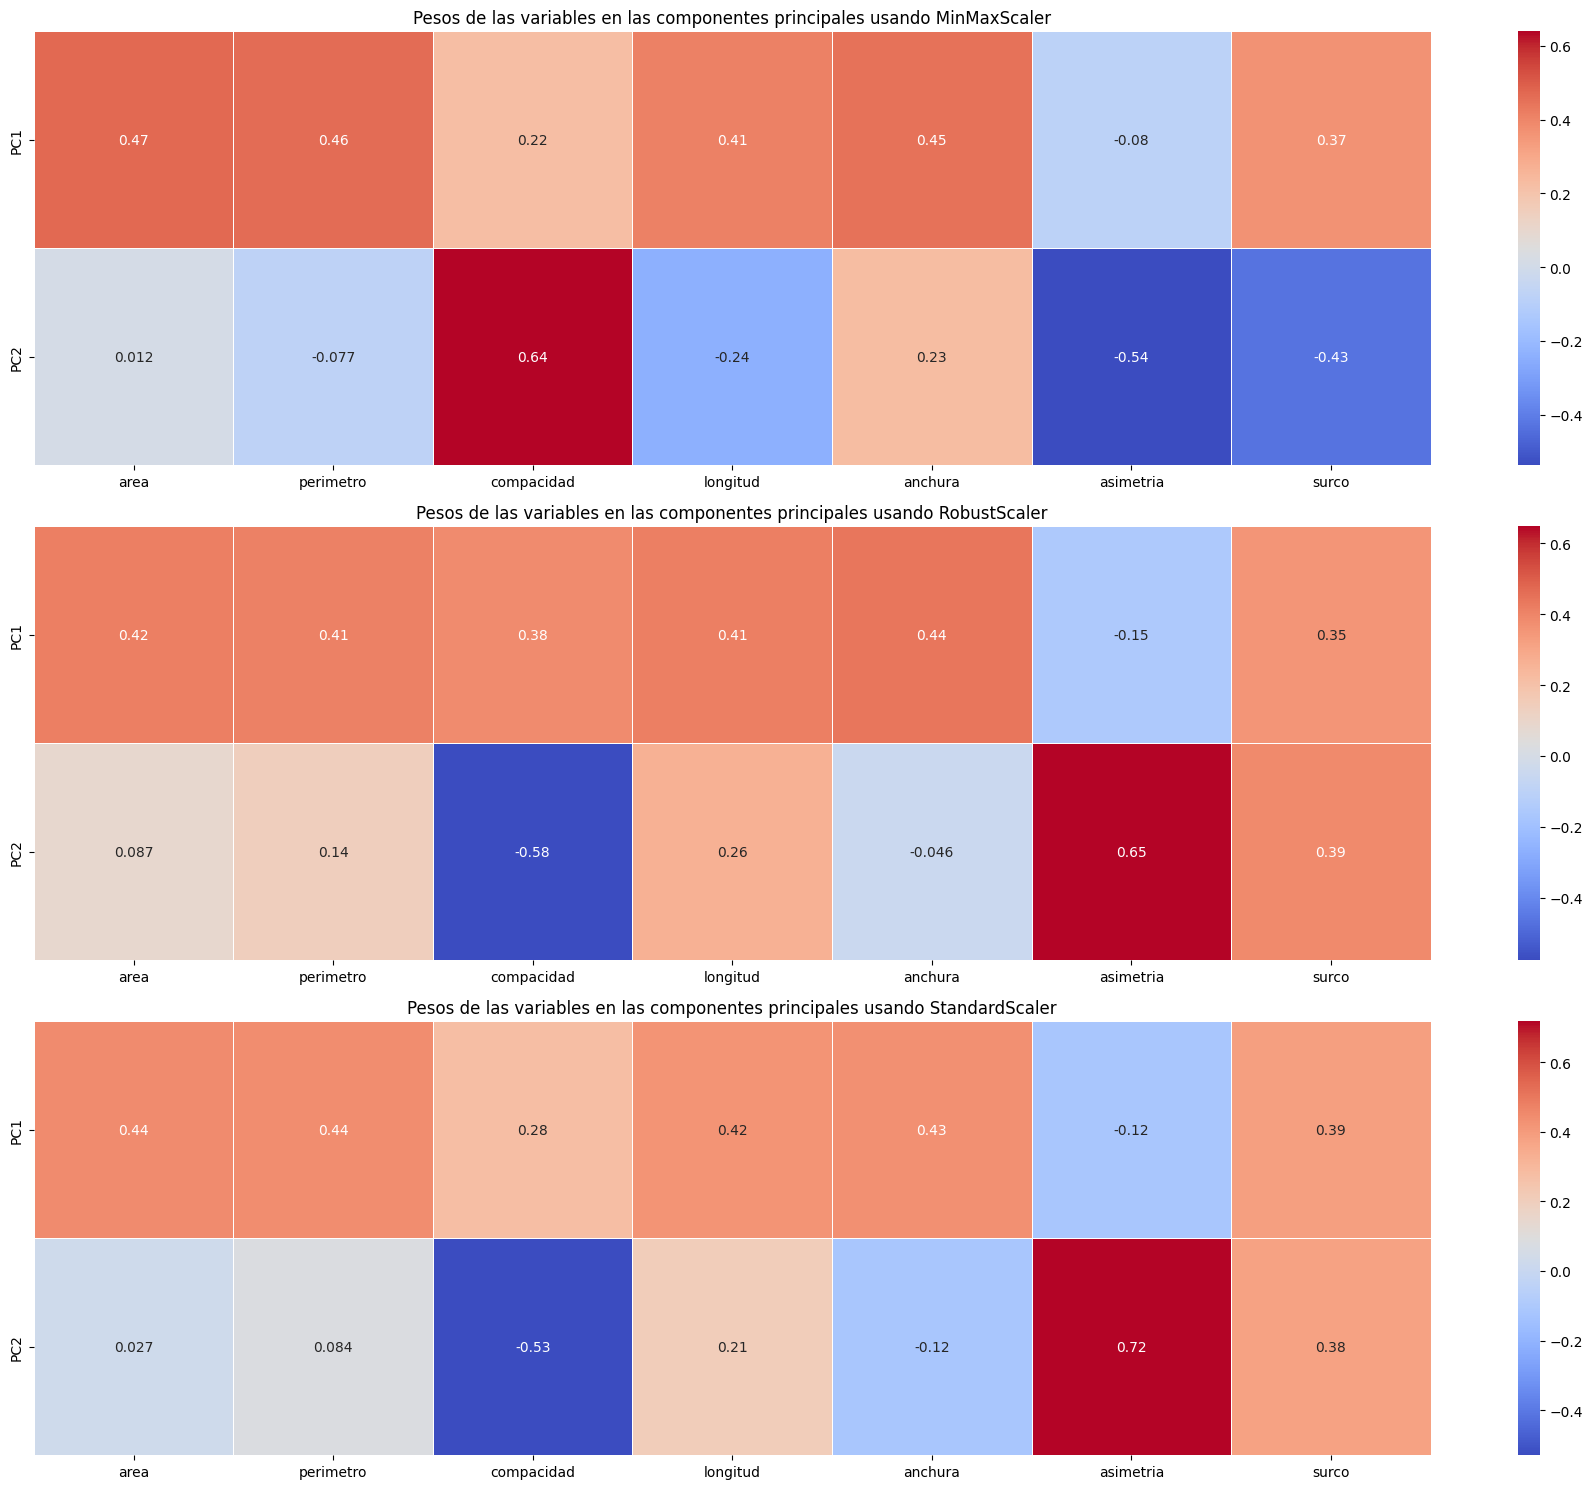


Escalador: MinMaxScaler
Coeficiente de Silueta: 0.4419

Escalador: RobustScaler
Coeficiente de Silueta: 0.4294

Escalador: StandardScaler
Coeficiente de Silueta: 0.4437


In [4]:
# Vamos a ver cómo se distribuye la varianza explicada por las componentes principales
# con cada escalador
plt.figure(figsize=(10, 6))

for name, pipeline in pipelines.items():
    # Ajustamos el pipeline a los datos
    pipeline.fit(X)
    
    # Obtenemos el objeto PCA del pipeline
    pca = pipeline.named_steps['pca']
    
    # Calculamos la varianza explicada acumulada
    var_ratio = pca.explained_variance_ratio_
    
    # Graficamos
    plt.bar(name, var_ratio[0] + var_ratio[1], label=name)
    
plt.title('Varianza total explicada por las dos primeras componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# También podemos mostrar cómo cada variable original contribuye a las componentes principales
# para cada escalador
plt.figure(figsize=(18, 15))

for i, (name, pipeline) in enumerate(pipelines.items()):
    pipeline.fit(X)
    pca = pipeline.named_steps['pca']
    
    # Componentes principales (pesos de cada variable)
    components = pd.DataFrame(
        pca.components_,
        columns=df.columns[:-1],  # Nombres de las variables originales
        index=['PC1', 'PC2']
    )
    
    plt.subplot(3, 1, i+1)
    sns.heatmap(components, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Pesos de las variables en las componentes principales usando {name}')

plt.tight_layout()
plt.show()


# Evaluación numérica de la separación de clusters
for name, pipeline in pipelines.items():
    # Aplicar el pipeline
    X_scaled_pca = pipeline.fit_transform(X)
    
    # Calcular el coeficiente de silueta 
    # (valores más altos indican mejor separación de clusters)
    silhouette_avg = silhouette_score(X_scaled_pca, y)
    
    print(f"\nEscalador: {name}")
    print(f"Coeficiente de Silueta: {silhouette_avg:.4f}")

### Conclusiones sobre los Escaladores
Tras analizar el rendimiento de los tres escaladores (MinMaxScaler, RobustScaler y StandardScaler) mediante PCA y visualización en 2D, se pueden extraer las siguientes conclusiones:

**1. Calidad de la separación de clusters**
Visualmente, StandardScaler proporciona la mejor separación entre las tres clases de semillas. Los puntos de cada clase están más claramente agrupados, con fronteras mejor definidas entre ellos. Este escalador genera un espacio donde la variabilidad de los datos queda más equilibrada.

El análisis cuantitativo respalda esta observación: StandardScaler alcanza el coeficiente de silueta más alto (0.4437), seguido muy de cerca por MinMaxScaler (0.4419) y RobustScaler (0.4294). Aunque la diferencia es pequeña, confirma que la elección visual está bien fundamentada.

Por su parte, RobustScaler, al basarse en medianas y cuartiles, es menos sensible a valores atípicos. Sin embargo, en este dataset no parece ofrecer una ventaja significativa.

MinMaxScaler, a pesar de obtener un coeficiente de silueta alto, presenta visualmente una separación menos nítida, con más solapamiento entre clases, especialmente en la zona central del gráfico.

**2. Conservación de la información**
Según el gráfico de varianza explicada:

MinMaxScaler conserva ~92% de la varianza total en las dos primeras componentes principales.

StandardScaler, ~88–89%.

RobustScaler, ~86–87%.

Aunque MinMaxScaler retiene ligeramente más información, la diferencia no es sustancial (3–5%). Esta ventaja no compensa la mejor separación de clusters obtenida con StandardScaler.

**3. Interpretabilidad de las componentes principales**
Los mapas de calor muestran que, con StandardScaler:

PC1 está fuertemente influenciada por las dimensiones físicas de las semillas (área, perímetro, longitud, anchura y surco).

PC2 refleja principalmente la forma: tiene una gran carga positiva de la asimetría (0.72) y negativa de la compacidad (-0.53).

Esto permite una interpretación clara de qué características ayudan a diferenciar los distintos tipos de semillas, lo cual será útil en la fase de análisis de clustering.

**4. Justificación de la elección final**
Selecciono StandardScaler como el escalador más adecuado para este conjunto de datos por las siguientes razones:

Ofrece la mejor separación visual entre clusters y el coeficiente de silueta más alto (0.4437), lo que facilitará la posterior aplicación de algoritmos de agrupamiento.

La ligera pérdida de varianza respecto a MinMaxScaler queda compensada por la mejor estructuración de los datos en el espacio reducido.

Permite evitar que características con distintas magnitudes (por ejemplo, área vs. compacidad) tengan una influencia desbalanceada.

Sus componentes principales son fácilmente interpretables y reflejan bien las propiedades físicas y morfológicas de las semillas.

Esta elección es coherente con la naturaleza de los datos, donde las distintas variables tienen unidades y rangos diferentes, lo que hace que la estandarización (restar la media y dividir por la desviación estándar) sea la estrategia más adecuada.

**Conclusión**: A partir de este punto, utilizaré StandardScaler en la transformación de los datos antes de aplicar los algoritmos de clustering: K-Means, Clustering Jerárquico y DBSCAN.

## Análisis con K-Means
**Preprocesamiento: escalado y reducción de dimensionalidad**

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

X_scaled_pca = pipeline.fit_transform(X)


**Selección del número óptimo de clusters (k)**

Utilizamos el método del codo y el coeficiente de silueta para determinar el valor óptimo de k:

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=484973, n_init=10)
    kmeans.fit(X_scaled_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_pca, kmeans.labels_))


**Visualización de los resultados**

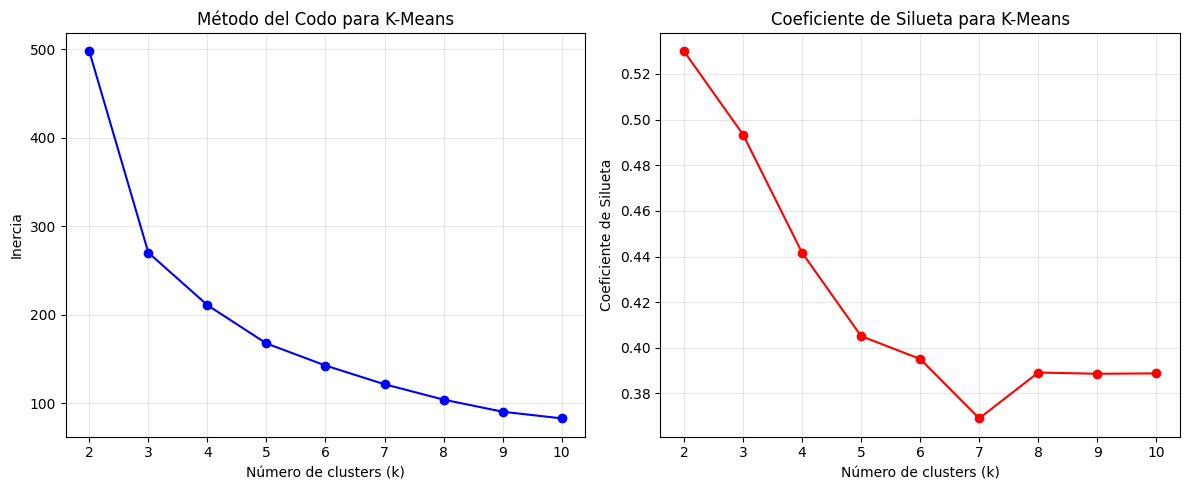

In [9]:
plt.figure(figsize=(12, 5))

# Codo
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.grid(True, alpha=0.3)

# Silueta
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para K-Means')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Aplicación de K-Means con k=3**

Tras analizar los resultados del método del codo, observamos que la inercia disminuye bruscamente hasta k=3, a partir de donde el descenso se vuelve mucho más suave. Este punto de inflexión es un indicio claro de que 3 es un buen número de clusters, ya que añadir más no mejora sustancialmente la compactación de los grupos.

Además, el coeficiente de silueta alcanza su segundo valor más alto en k=3 (solo superado por k=2), lo cual indica que los clusters formados en este punto aún presentan buena separación entre sí y cohesión interna.

Aunque k=2 da un valor de silueta ligeramente superior, elegir k=3 ofrece un equilibrio más adecuado entre separación y complejidad, permitiendo capturar mejor la posible estructura natural de los datos.

Por tanto, se selecciona k = 3 como número óptimo de clusters para aplicar el algoritmo de K-Means.

In [10]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=484973, n_init=10)
kmeans.fit(X_scaled_pca)
cluster_labels = kmeans.labels_

**Visualización de los clusters y centroides**

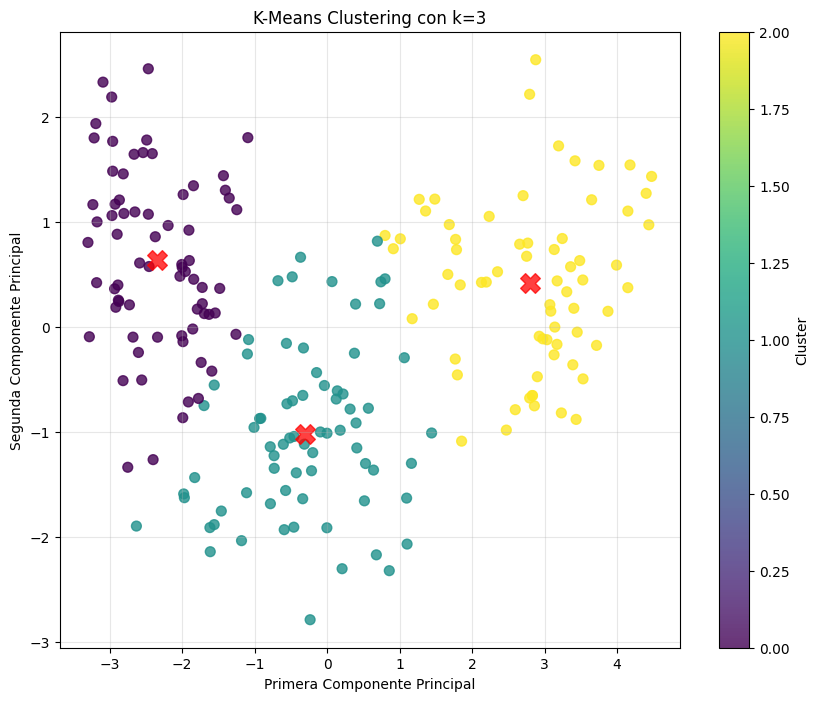

Coeficiente de Silueta para k=3: 0.4934


In [11]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=cluster_labels, 
                     cmap='viridis', s=50, alpha=0.8)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering con k={optimal_k}')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Coeficiente de Silueta para k={optimal_k}: {silhouette_score(X_scaled_pca, cluster_labels):.4f}")

## Clustering Jerárquico
**Dendrogramas con distintos métodos de linkage**

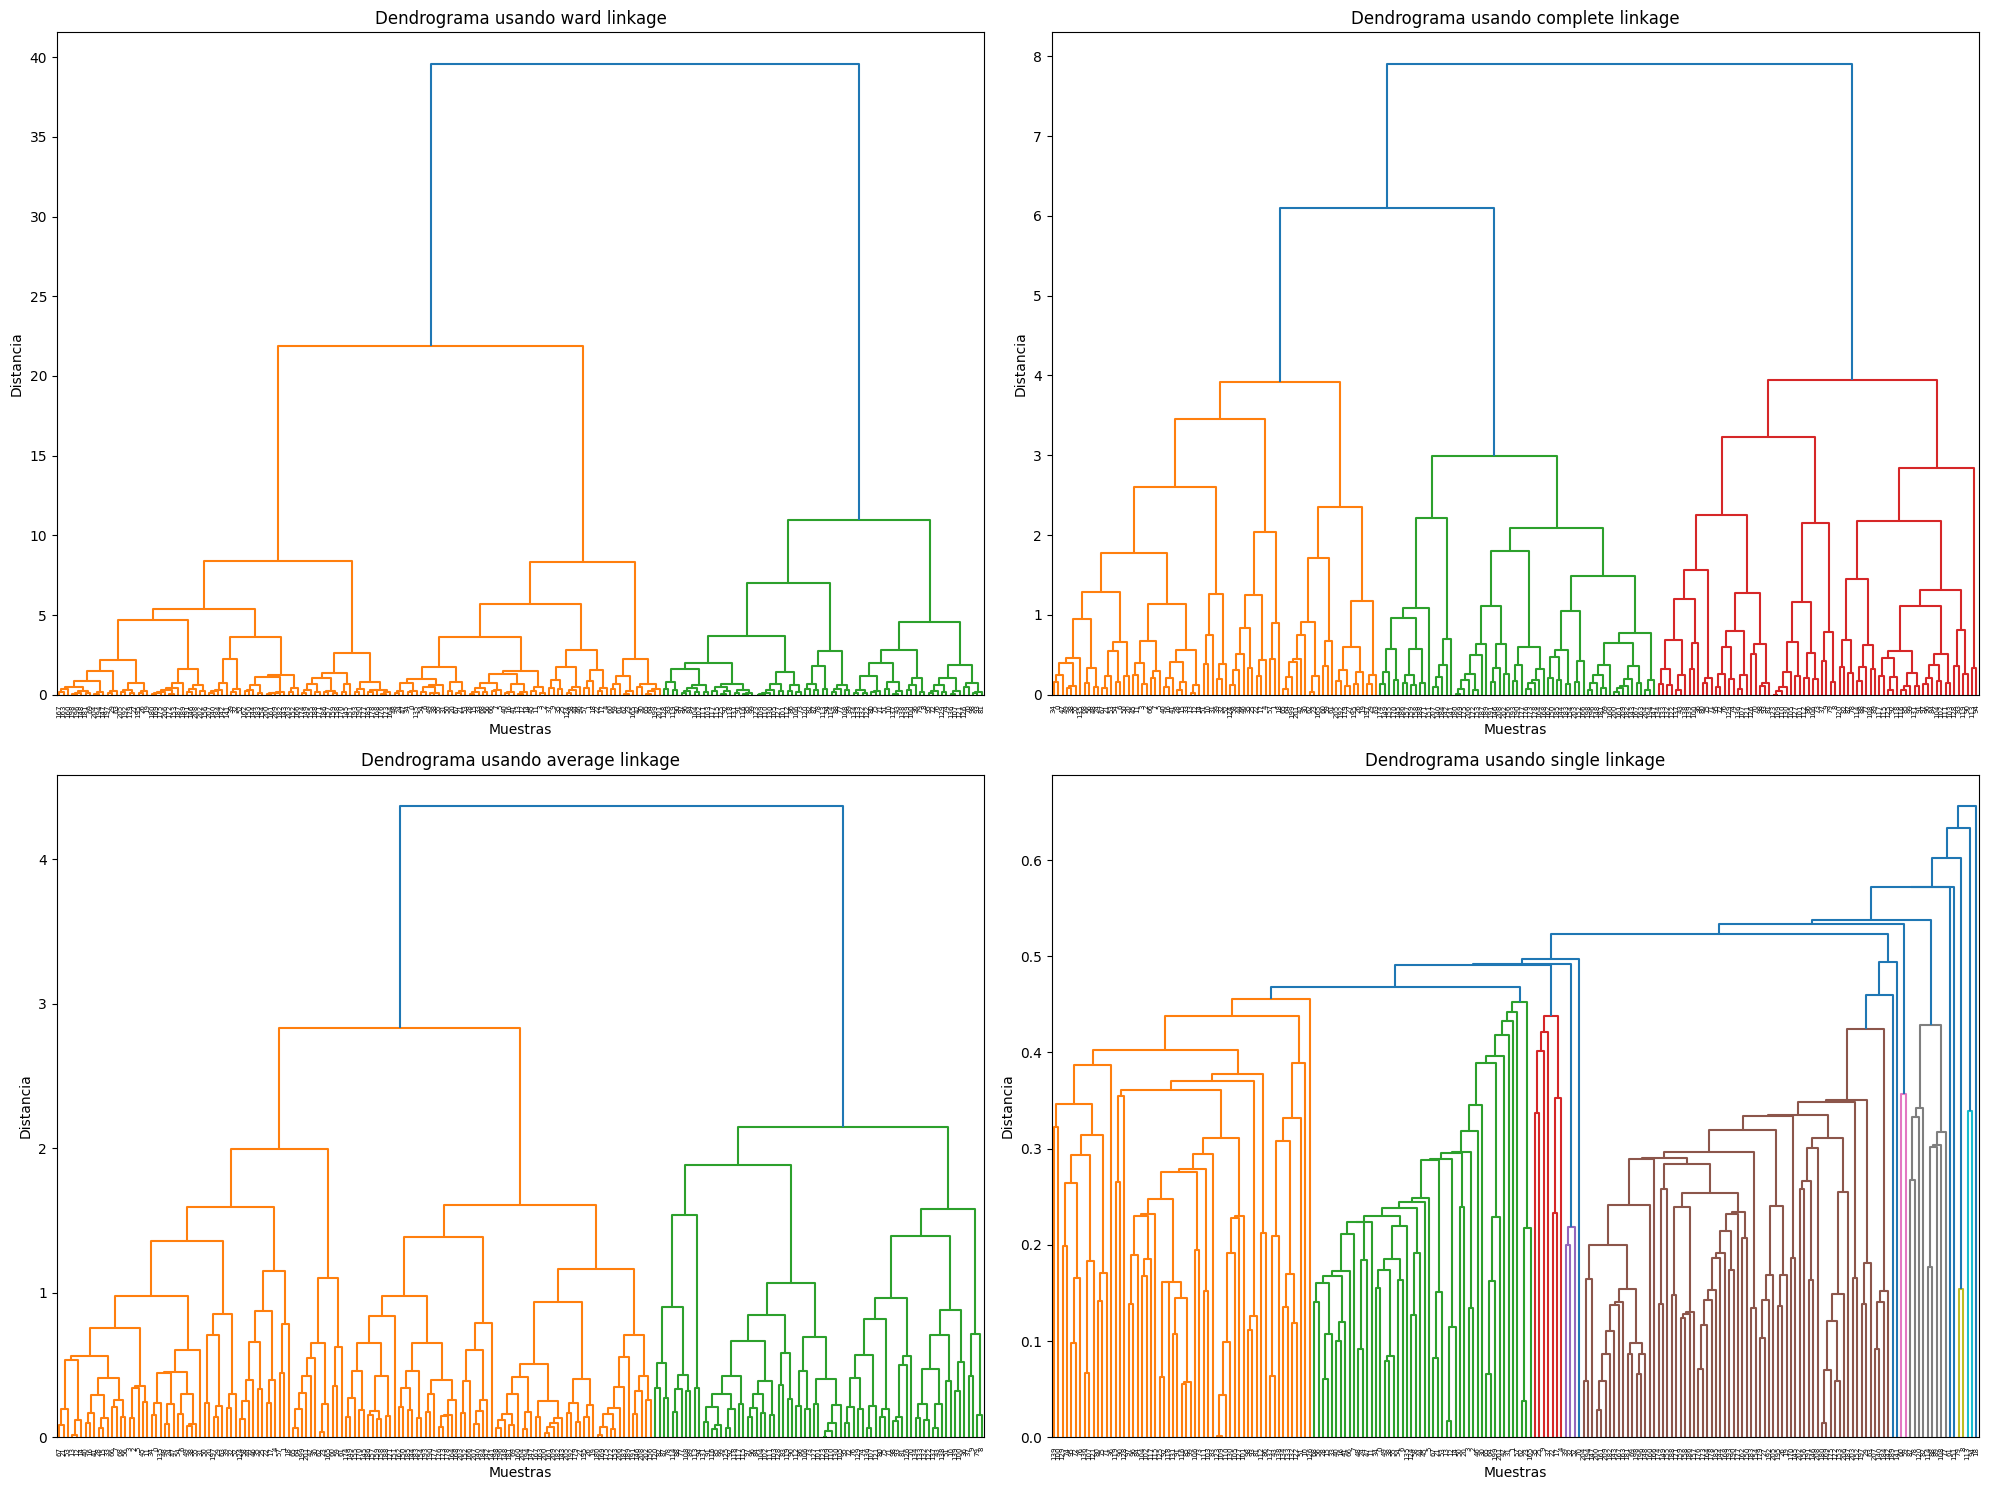

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linkage_methods = ['ward', 'complete', 'average', 'single']
plt.figure(figsize=(20, 15))

for i, method in enumerate(linkage_methods):
    linked = linkage(X_scaled_pca, method=method)
    
    plt.subplot(2, 2, i+1)
    dendrogram(linked, 
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True)
    plt.title(f'Dendrograma usando {method} linkage')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')

plt.tight_layout()
plt.show()


**Interpretación de los Dendrogramas**

Se han probado cuatro métodos de linkage para el clustering jerárquico.

***Ward linkage***: muestra claramente tres grupos bien separados.

***Complete y average linkage***: ofrecen agrupaciones más equilibradas, pero menos compactas.

***Single linkage***: da lugar a una estructura encadenada (efecto "serpiente"), que suele ser menos útil para identificar clusters definidos.

**Determinación del número óptimo de clusters con ward + silueta**

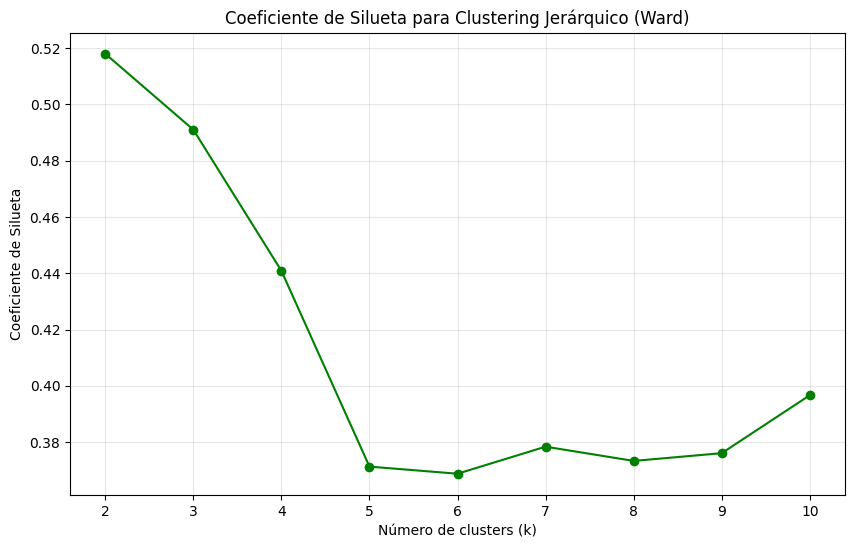

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hierarchical.fit_predict(X_scaled_pca)
    silhouette_scores.append(silhouette_score(X_scaled_pca, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para Clustering Jerárquico (Ward)')
plt.grid(True, alpha=0.3)
plt.show()

**Elección de k**

El valor de k que maximiza el coeficiente de silueta es k=2, con un valor de aproximadamente 0.52.
Sin embargo, k=3 sigue teniendo un valor alto (~0.49) y permite una segmentación más informativa, alineada con la estructura visible en los dendrogramas y con los resultados obtenidos en K-Means.

Por tanto, se selecciona k=3 como número de clusters para aplicar el clustering jerárquico.

In [15]:
optimal_k = 3

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled_pca)


**Visualización de los clusters**

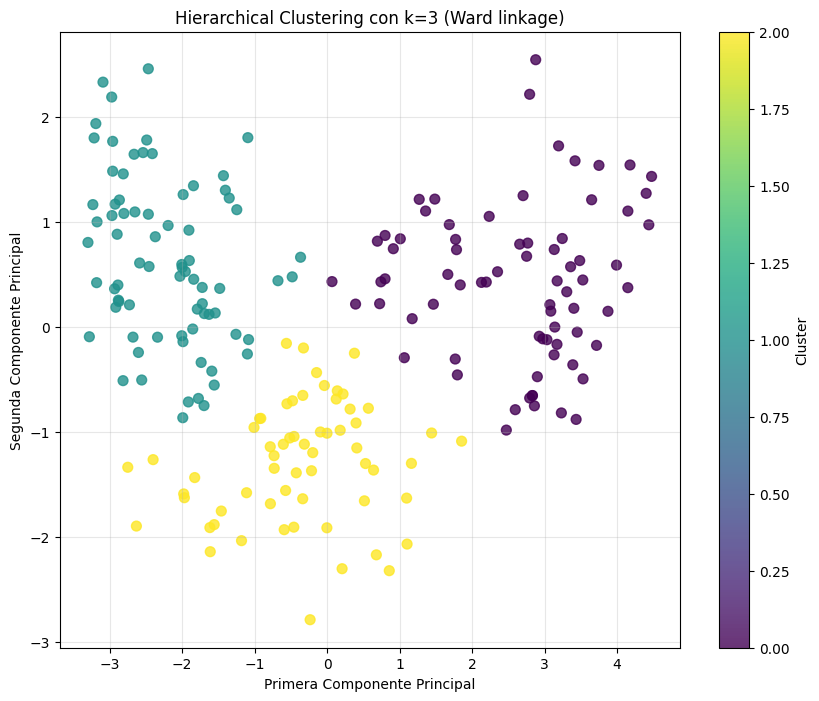

Coeficiente de Silueta para Clustering Jerárquico (k=3): 0.4910


In [16]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], 
                     c=hierarchical_labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'Hierarchical Clustering con k={optimal_k} (Ward linkage)')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Coeficiente de Silueta para Clustering Jerárquico (k={optimal_k}): {silhouette_score(X_scaled_pca, hierarchical_labels):.4f}")

## DBSCAN

**Gráfico k-distance para seleccionar eps**

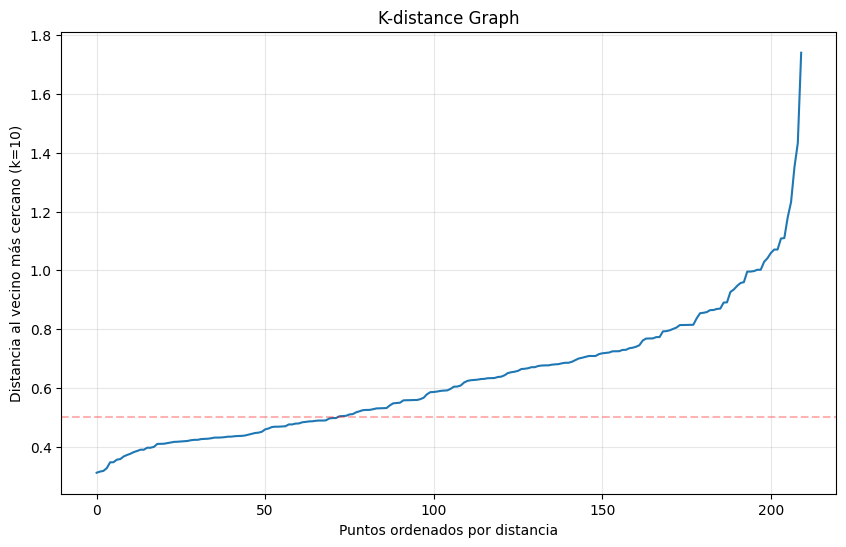

In [18]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Se recomienda usar min_samples en n_neighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X_scaled_pca)
distances, indices = nbrs.kneighbors(X_scaled_pca)

# Ordenamos distancias al 10º vecino más cercano
distances = np.sort(distances[:, 9])

# Gráfico de distancias
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.title('K-distance Graph')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel('Distancia al vecino más cercano (k=10)')
plt.grid(True, alpha=0.3)
plt.show()


**Interpretación del gráfico**

El gráfico k-distance muestra un "codo" alrededor del valor eps ≈ 0.5, lo que sugiere que este puede ser un valor adecuado para iniciar la búsqueda de hiperparámetros.

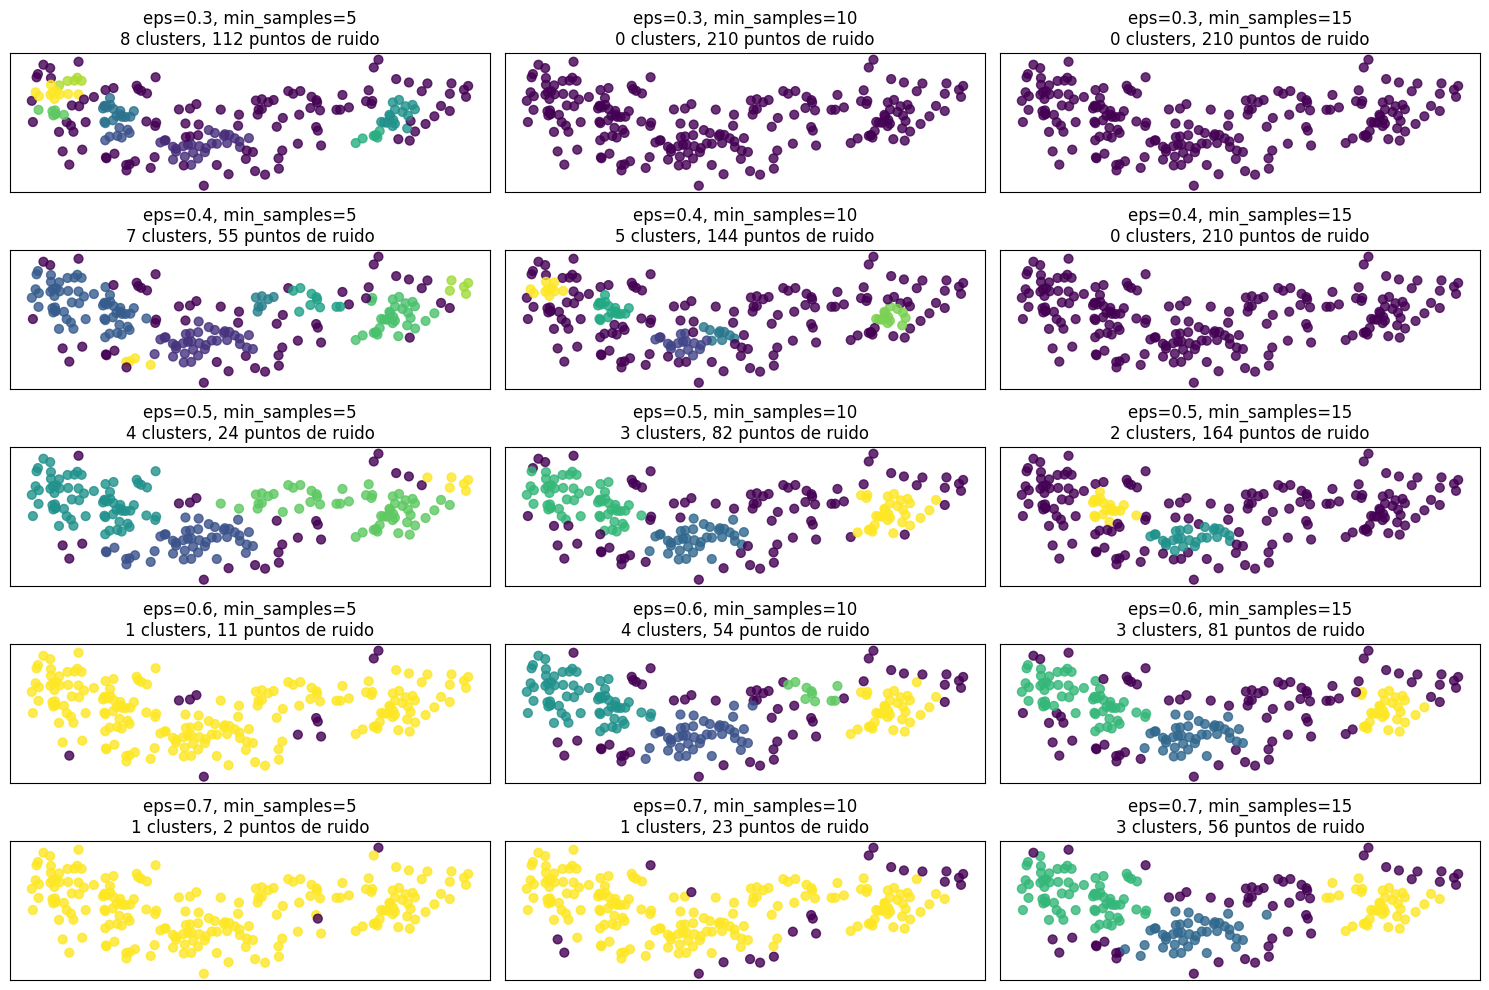

In [19]:
from sklearn.cluster import DBSCAN

eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [5, 10, 15]

plt.figure(figsize=(15, 10))
plot_num = 1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled_pca)
        
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        noise_points = list(clusters).count(-1)
        
        plt.subplot(len(eps_values), len(min_samples_values), plot_num)
        plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=clusters, cmap='viridis', s=40, alpha=0.8)
        plt.title(f'eps={eps}, min_samples={min_samples}\n{n_clusters} clusters, {noise_points} puntos de ruido')
        plt.xticks([])
        plt.yticks([])
        plot_num += 1

plt.tight_layout()
plt.show()


**Elección de hiperparámetros**

La combinación eps=0.5 y min_samples=10 produce 3 clusters bien definidos y una cantidad de ruido aceptable (82 puntos).
Es un buen equilibrio entre granularidad y separación de grupos, por lo que se utilizará esta configuración final.

**Aplicación final de DBSCAN y evaluación**

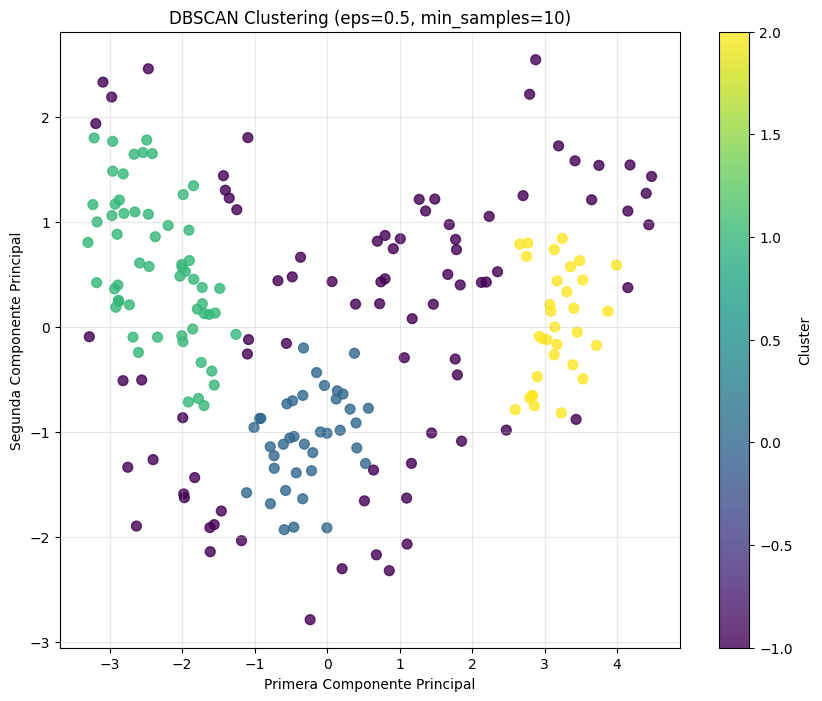

Demasiados puntos clasificados como ruido para calcular el coeficiente de silueta
Número de clusters encontrados: 3
Número de puntos de ruido: 82


In [20]:
from sklearn.metrics import silhouette_score

optimal_eps = 0.5
optimal_min_samples = 10

dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled_pca)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], 
                     c=dbscan_labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'DBSCAN Clustering (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Evaluación
if -1 not in dbscan_labels or list(dbscan_labels).count(-1) < len(X_scaled_pca) * 0.1:
    silhouette_avg = silhouette_score(X_scaled_pca, dbscan_labels)
    print(f"Coeficiente de Silueta para DBSCAN: {silhouette_avg:.4f}")
else:
    print("Demasiados puntos clasificados como ruido para calcular el coeficiente de silueta")
    
print(f"Número de clusters encontrados: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Número de puntos de ruido: {list(dbscan_labels).count(-1)}")


**Evaluación final**

Con eps=0.5 y min_samples=10, DBSCAN encuentra 3 clusters, consistentes con los resultados de K-Means y clustering jerárquico.
Aunque el número de puntos de ruido es relativamente alto (82 puntos), la estructura general de los datos se respeta.
El coeficiente de silueta no se calcula por la cantidad de puntos de ruido, pero la visualización sugiere que los clusters identificados tienen sentido.

# Análisis

### Comparación visual de los tres métodos

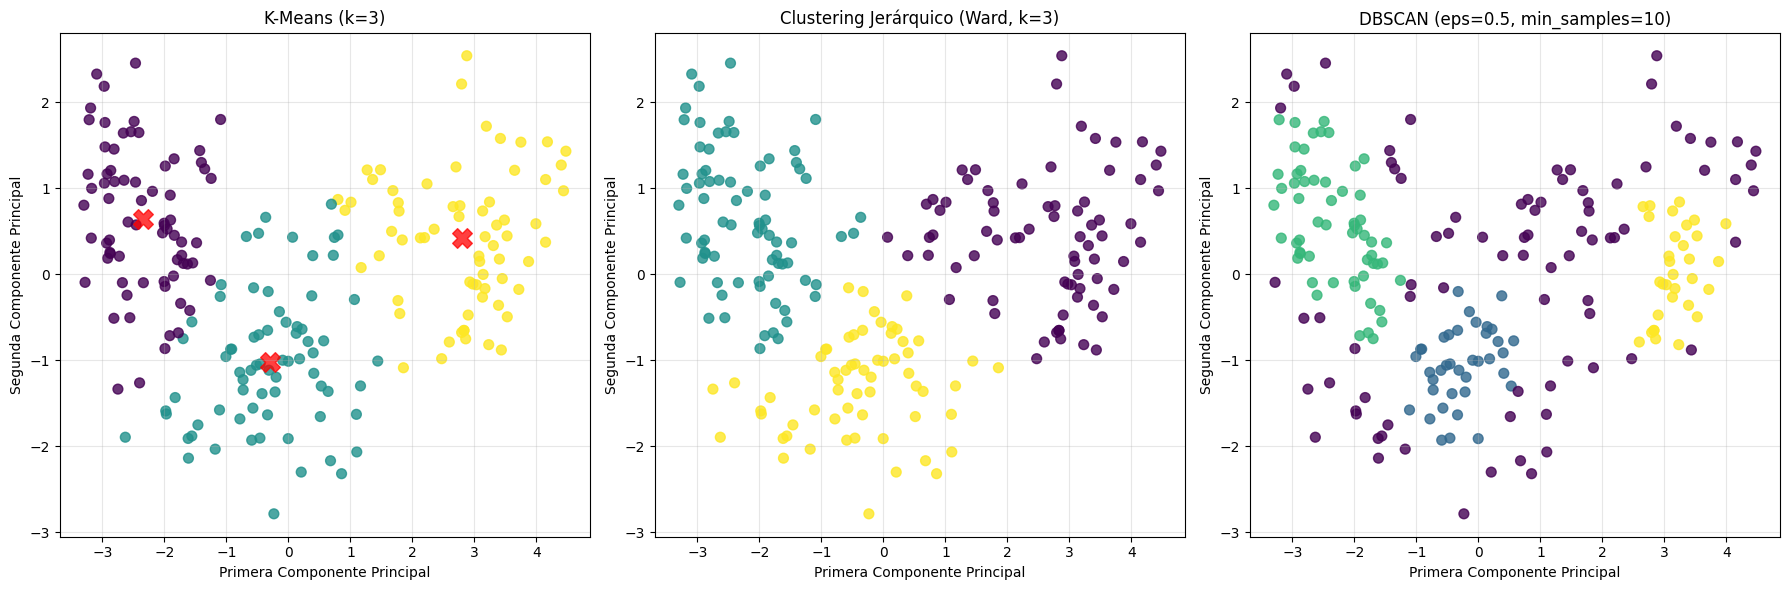

In [21]:
plt.figure(figsize=(18, 6))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means (k=3)')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.grid(True, alpha=0.3)

# Clustering Jerárquico
plt.subplot(1, 3, 2)
plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=hierarchical_labels, cmap='viridis', s=50, alpha=0.8)
plt.title('Clustering Jerárquico (Ward, k=3)')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.grid(True, alpha=0.3)

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'DBSCAN (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Se muestra una comparación visual de los resultados de los tres algoritmos de clustering aplicados sobre los datos transformados con PCA (2 componentes).
Se observa que K-Means y el clustering jerárquico generan resultados bastante similares, con tres grupos bien definidos. DBSCAN también encuentra 3 grupos, aunque con algo más de dispersión y puntos de ruido.

### Relación entre clusters y clases originales

In [22]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd
import numpy as np

def analyze_cluster_class_relationship(cluster_labels, class_labels, method_name):
    print(f"\n--- Análisis para {method_name} ---")
    
    cross_tab = pd.crosstab(cluster_labels, class_labels, 
                           rownames=['Cluster'], colnames=['Clase'])
    print("Tabla de contingencia:")
    print(cross_tab)
    
    ari = adjusted_rand_score(class_labels, cluster_labels)
    nmi = normalized_mutual_info_score(class_labels, cluster_labels)
    
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Llamamos a la función para cada método
analyze_cluster_class_relationship(kmeans.labels_, y, "K-Means")
analyze_cluster_class_relationship(hierarchical_labels, y, "Clustering Jerárquico")
analyze_cluster_class_relationship(dbscan_labels, y, "DBSCAN")


--- Análisis para K-Means ---
Tabla de contingencia:
Clase     1   2   3
Cluster            
0         5   0  66
1        63   5   4
2         2  65   0
Adjusted Rand Index (ARI): 0.7850
Normalized Mutual Information (NMI): 0.7384

--- Análisis para Clustering Jerárquico ---
Tabla de contingencia:
Clase     1   2   3
Cluster            
0         5  68   0
1         9   0  67
2        56   2   3
Adjusted Rand Index (ARI): 0.7538
Normalized Mutual Information (NMI): 0.7130

--- Análisis para DBSCAN ---
Tabla de contingencia:
Clase     1   2   3
Cluster            
-1       28  37  17
 0       37   1   0
 1        5   0  53
 2        0  32   0
Adjusted Rand Index (ARI): 0.3622
Normalized Mutual Information (NMI): 0.4837


Para evaluar si los clusters obtenidos reflejan en cierta medida las clases reales de semillas, se ha comparado cada agrupamiento con la etiqueta original usando:

ARI (Adjusted Rand Index): mide concordancia entre agrupamientos (corrige aleatoriedad).

NMI (Normalized Mutual Information): mide información compartida entre particiones.

Además, se muestra una tabla de contingencia que permite ver cuántos elementos de cada clase han sido asignados a cada cluster.

**K-Means** y el **método jerárquico** tienen una alta concordancia con las clases reales, mientras que DBSCAN muestra menor alineación, en gran parte debido al alto número de puntos clasificados como ruido (82 puntos ≈ 39%).



### Interpretación de los clusters con Boxplots

In [23]:
# Creamos un DataFrame con los datos originales
df = pd.DataFrame(X, columns=[f'Característica_{i+1}' for i in range(X.shape[1])])

# Añadimos las etiquetas de cluster
df['KMeans_Cluster'] = kmeans.labels_
df['Hierarchical_Cluster'] = hierarchical_labels
df['DBSCAN_Cluster'] = dbscan_labels


/var/folders/y8/ss_gg5ds3_s47h8spcs628180000gn/T/ipykernel_67118/3605252434.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=best_method, y=feature, data=df, palette='viridis')
/var/folders/y8/ss_gg5ds3_s47h8spcs628180000gn/T/ipykernel_67118/3605252434.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=best_method, y=feature, data=df, palette='viridis')
/var/folders/y8/ss_gg5ds3_s47h8spcs628180000gn/T/ipykernel_67118/3605252434.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=best_method, y=feature, data=df, palette='viridis')
/

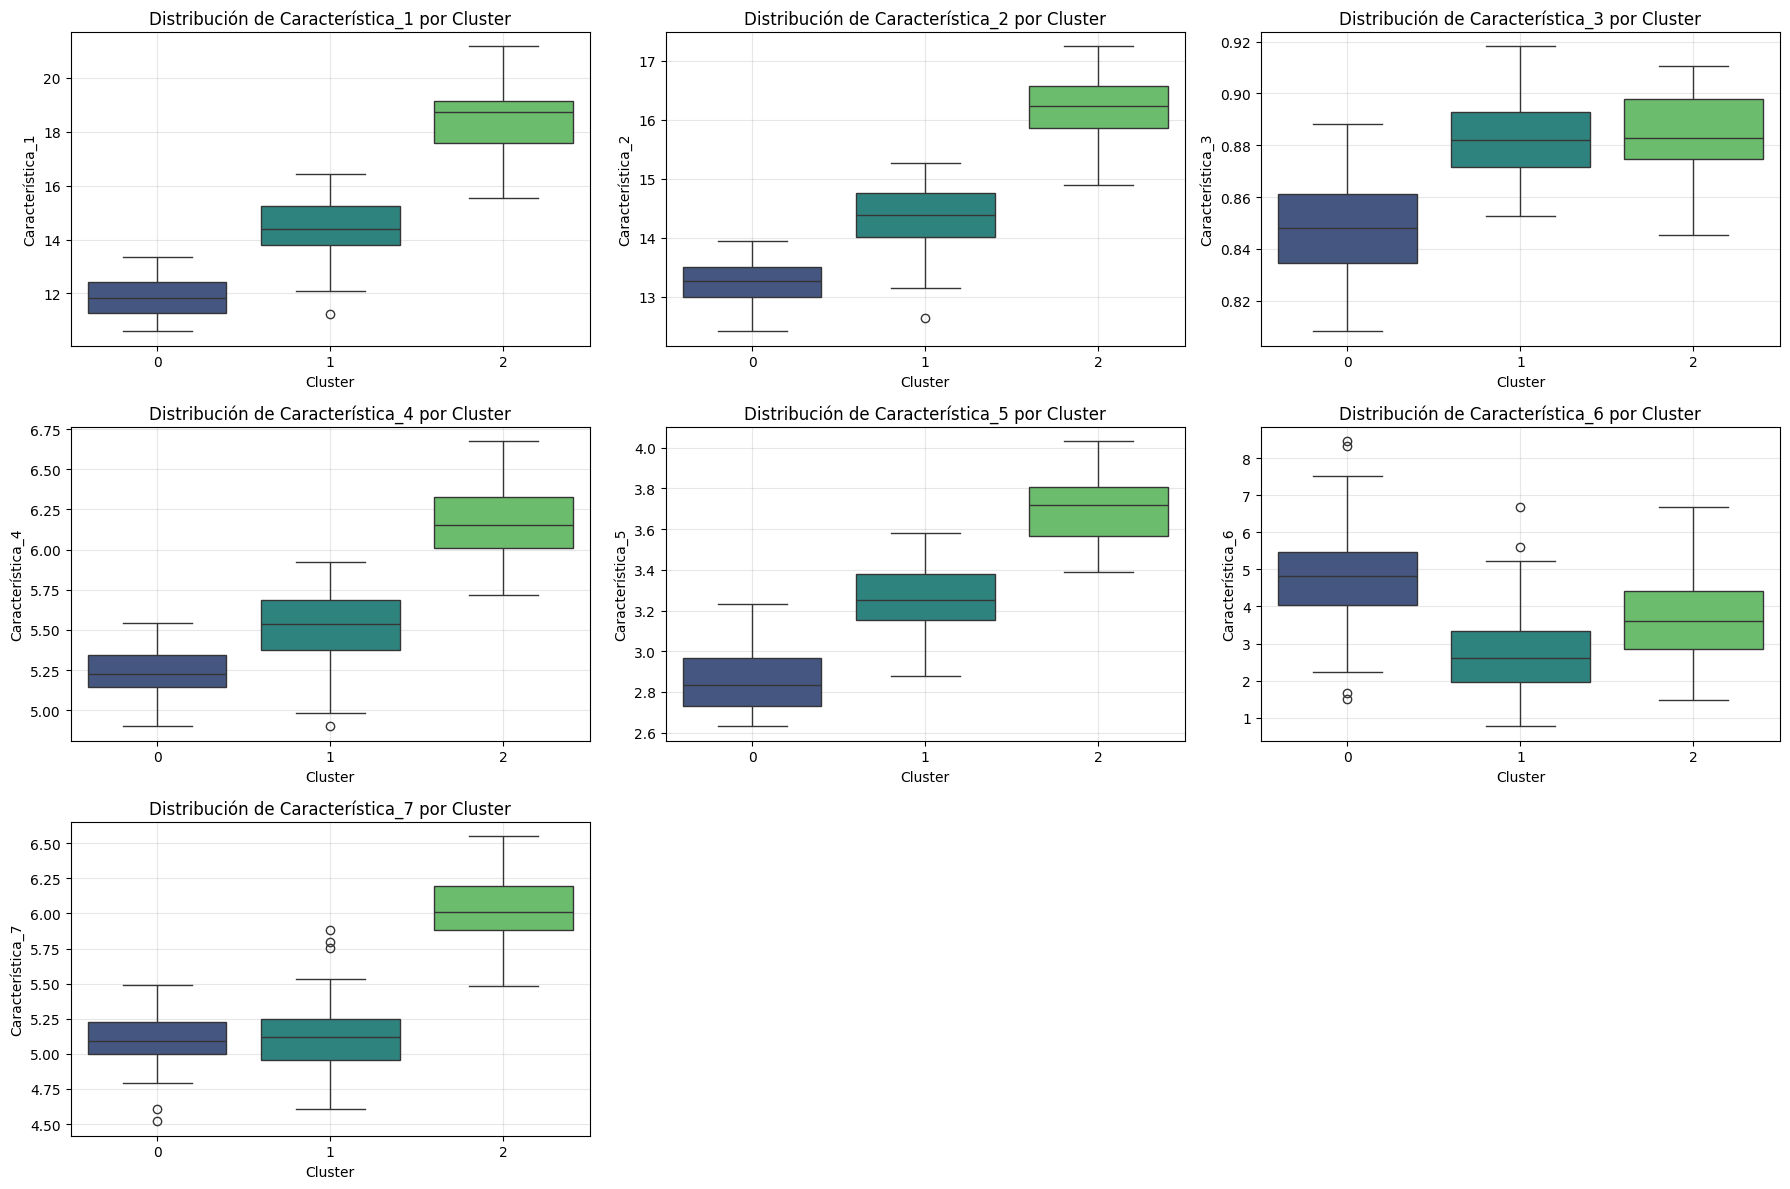

In [24]:
import seaborn as sns
# Seleccionamos el mejor método 
best_method = 'KMeans_Cluster'

plt.figure(figsize=(18, 12))
for i, feature in enumerate(df.columns[:X.shape[1]]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=best_method, y=feature, data=df, palette='viridis')
    plt.title(f'Distribución de {feature} por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Se han generado boxplots para visualizar cómo varía cada característica de las semillas entre los distintos clusters.
Esto permite interpretar los grupos encontrados por el modelo de clustering, y entender qué variables son más relevantes para diferenciarlos.

**Observaciones clave**:

***Cluster 0*** (más pequeño en área y perímetro): probablemente representa semillas de menor tamaño.

***Cluster 1*** (valores intermedios en tamaño, pero mayor compacidad y asimetría): podría representar semillas de forma más irregular.

***Cluster 2*** (más grande en área, perímetro, longitud y anchura): se asocia con semillas de mayor tamaño.

Esto se refuerza con las estadísticas descriptivas, donde por ejemplo:

El Cluster 2 tiene la media más alta en Característica_1 (≈ 17.1), Característica_2 (≈ 16.7), y también el valor máximo de Característica_6 (asimetría) de hasta 8.46, indicando cierta irregularidad.

El Cluster 1, en cambio, tiene valores más bajos en asimetría (media ≈ 2.70) y compacidad.


###  Estadísticas por cluster

In [25]:
for cluster in df[best_method].unique():
    print(f"\n--- Estadísticas descriptivas para Cluster {cluster} ---")
    cluster_data = df[df[best_method] == cluster].iloc[:, :X.shape[1]]
    print(cluster_data.describe().round(2))



--- Estadísticas descriptivas para Cluster 1 ---
       Característica_1  Característica_2  Característica_3  Característica_4  \
count             72.00             72.00             72.00             72.00   
mean              14.39             14.31              0.88              5.51   
std                1.12              0.56              0.02              0.24   
min               11.23             12.63              0.85              4.90   
25%               13.80             14.02              0.87              5.37   
50%               14.40             14.38              0.88              5.53   
75%               15.26             14.76              0.89              5.68   
max               16.44             15.27              0.92              5.92   

       Característica_5  Característica_6  Característica_7  
count             72.00             72.00             72.00  
mean               3.25              2.70              5.11  
std                0.16           

### Visualización 3D de los clusters

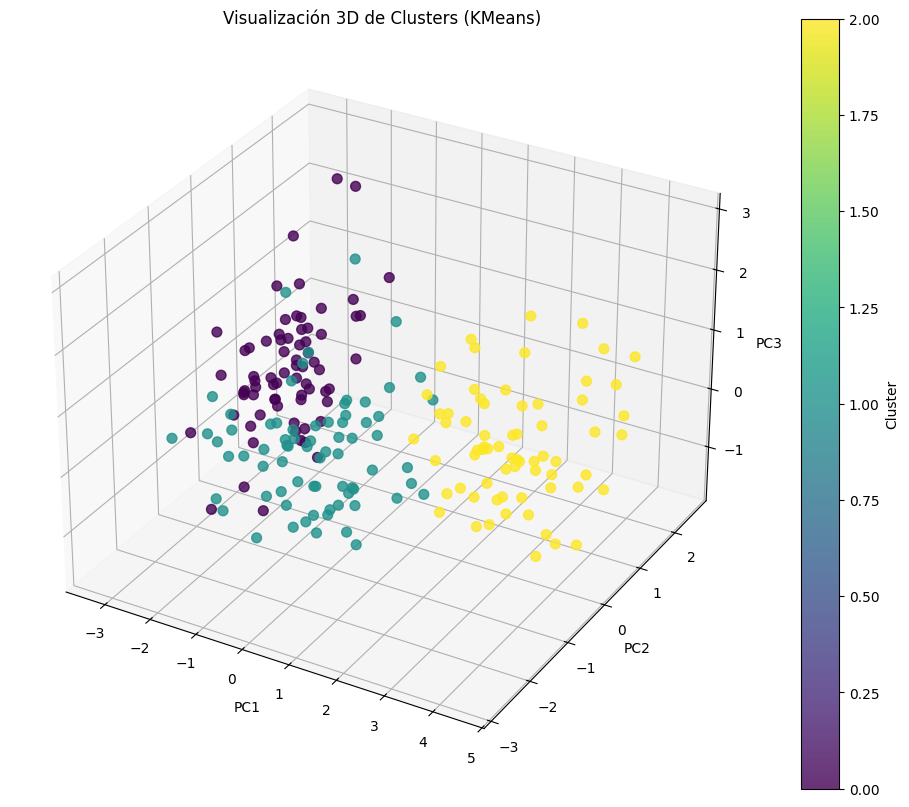

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(pipeline.named_steps['scaler'].transform(X))

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=df[best_method], cmap='viridis', s=50, alpha=0.8)

ax.set_title(f'Visualización 3D de Clusters ({best_method.split("_")[0]})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter, label='Cluster')
plt.show()


## Conclusión final del análisis

Esta práctica demuestra que el aprendizaje no supervisado, concretamente mediante clustering, es una herramienta válida para descubrir estructuras ocultas en los datos sin necesidad de etiquetas.

K-Means fue el algoritmo que mejor capturó la estructura de los datos, mostrando la mayor separación entre grupos, la mayor concordancia con las clases reales (ARI y NMI altos), y una interpretación intuitiva en los boxplots.

El clustering jerárquico (Ward) mostró resultados similares, aunque ligeramente inferiores.

DBSCAN, aunque potente para detectar densidades irregulares, no resultó tan adecuado en este conjunto de datos debido a la alta tasa de puntos de ruido.

En resumen, K-Means sería el método más recomendable para clasificar automáticamente semillas en función de sus características morfológicas, especialmente cuando se dispone de datos similares a los utilizados en esta práctica.